<a href="https://colab.research.google.com/github/amogh-code2021/Tutorials_1/blob/master/NLP_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Installing and importing all necessary packages
!pip install tensorflow_text
!pip install contractions

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import re
import string
import os
from bs4 import BeautifulSoup

from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
#train = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Assignment/train.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.shape

(7613, 5)

In [ ]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train_disaster = train[train['target'] == 1]
train_other = train[train['target'] == 0]

In [ ]:
print(train_disaster.head())
print(train_other.head())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]
    id keyword location                          text  target
15  23     NaN      NaN                What's up man?       0
16  24     NaN      NaN                 I love fruits       0
17  25     NaN      NaN              Summer is lovely       0
18  26     NaN      NaN             My car is so fast       0
19  28     NaN      NaN  What a goooooooaaaaaal!!!!!!       0


In [ ]:
#working on fixing the imbalanced data

train_other_downsized = train_other.sample(train_disaster.shape[0])
train_balanced = pd.concat([train_disaster, train_other_downsized])
train_balanced['target'].value_counts()

1    3271
0    3271
Name: target, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_balanced['text'],train_balanced['target'], stratify=train_balanced['target'])

In [ ]:
#Creating data cleaning functions to clean the text data for our second model
#We will not be fixing any data imbalance here

def remove_tweet_username(df):
    return re.sub('@[^\s]+','', df)

def make_lower(df):
    return df.lower()

def cont_exp(df):
    return contractions.fix(df)

def make_string(df):
    return str(df)

def remove_url(df):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , df)

def remove_email(df):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", df)

#Retweets
def remove_rt(df):
    df = str(df)
    return re.sub(r'\brt\b', "", df).strip()

def remove_html(df):
    return BeautifulSoup(df, 'lxml').get_text().strip()


def remove_dots(df):
    dot_pattern = re.compile(r'\.{1,}')
    single_dot = dot_pattern.sub(' ', df)
    return single_dot

def remove_special_chars(df):
    df = re.sub(r'[^\w]+', " ", df)
    df = ' '.join(df.split())
    
    return df

def make_base(df):
    df = str(df)
    x_list = []
    doc = nlp(df)

    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

def spelling_correction(df):
    df = TextBlob(df).correct()
    return df

def resub(df):
    return re.sub("(.)\\1{2,}", "\\1", df)



def get_clean_data(df):
    df = remove_url(df)
    df = remove_email(df)
    df = remove_html(df)
    df = make_lower(df)
    df = make_string(df)
    df = cont_exp(df)
    df = remove_rt(df)
    df = resub(df)                             
    df = remove_tweet_username(df)
    
    return df

In [ ]:
#cleaning data

train_2 = pd.DataFrame(train)

train_2['text'] = train['text'].apply(get_clean_data)
train_2['text'] = train_2['text'].apply(remove_special_chars)
train_2['text'] = train_2['text'].str.replace('\d+', '')

In [ ]:
train_2['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

train_2['text'] = train_2['text'].apply(remove_stopwords)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train_2['text'],train_2['target'], stratify=train_2['target'])

In [ ]:
#Building model

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model_2 = tf.keras.Model(inputs=[text_input], outputs = [l])


In [ ]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
hist_1 = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
154/154 [==============================] - 38s 197ms/step - loss: 0.6593 - accuracy: 0.6135 - precision: 0.6092 - recall: 0.6335
Epoch 2/10
154/154 [==============================] - 30s 197ms/step - loss: 0.6067 - accuracy: 0.6822 - precision: 0.6816 - recall: 0.6841
Epoch 3/10
154/154 [==============================] - 30s 197ms/step - loss: 0.5971 - accuracy: 0.6900 - precision: 0.6890 - recall: 0.6926
Epoch 4/10
154/154 [==============================] - 30s 196ms/step - loss: 0.5905 - accuracy: 0.6993 - precision: 0.6981 - recall: 0.7024
Epoch 5/10
154/154 [==============================] - 30s 197ms/step - loss: 0.5750 - accuracy: 0.7083 - precision: 0.7087 - recall: 0.7073
Epoch 6/10
154/154 [==============================] - 30s 196ms/step - loss: 0.5643 - accuracy: 0.7140 - precision: 0.7146 - recall: 0.7126
Epoch 7/10
154/154 [==============================] - 30s 197ms/step - loss: 0.5579 - accuracy: 0.7263 - precision: 0.7301 - recall: 0.7179
Epoch 8/10
154/154 [

In [ ]:
hist_2 = model_2.fit(X_train_2, y_train_2, epochs=10)

Epoch 1/10
179/179 [==============================] - 37s 195ms/step - loss: 0.5412 - accuracy: 0.7379 - precision: 0.7403 - recall: 0.6669
Epoch 2/10
179/179 [==============================] - 35s 196ms/step - loss: 0.5319 - accuracy: 0.7483 - precision: 0.7433 - recall: 0.6327
Epoch 3/10
179/179 [==============================] - 35s 196ms/step - loss: 0.5239 - accuracy: 0.7542 - precision: 0.7498 - recall: 0.6425
Epoch 4/10
179/179 [==============================] - 35s 195ms/step - loss: 0.5209 - accuracy: 0.7528 - precision: 0.7446 - recall: 0.6466
Epoch 5/10
179/179 [==============================] - 35s 195ms/step - loss: 0.5190 - accuracy: 0.7571 - precision: 0.7526 - recall: 0.6474
Epoch 6/10
179/179 [==============================] - 35s 196ms/step - loss: 0.5132 - accuracy: 0.7593 - precision: 0.7534 - recall: 0.6539
Epoch 7/10
179/179 [==============================] - 35s 196ms/step - loss: 0.5130 - accuracy: 0.7628 - precision: 0.7574 - recall: 0.6592
Epoch 8/10
179/179 [

In [ ]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 11s 193ms/step - loss: 0.6300 - accuracy: 0.6718 - precision: 0.9350 - recall: 0.3692


[0.6299998164176941,
 0.6717603802680969,
 0.9349845051765442,
 0.3691931664943695]

In [ ]:
model_2.evaluate(X_test_2, y_test_2)

60/60 [==============================] - 12s 193ms/step - loss: 0.5266 - accuracy: 0.7621 - precision: 0.8361 - recall: 0.5550


[0.5265973210334778,
 0.7620798349380493,
 0.8360957503318787,
 0.5550122261047363]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted_1 = y_predicted

y_predicted_2 = model.predict(X_test_2)
y_predicted_2 = y_predicted_2.flatten()
y_predicted_3 = y_predicted_2

y_predicted = np.where(y_predicted_1 > 0.55, 1, 0)
print(y_predicted)

y_predicted_2 = np.where(y_predicted_3 > 0.55, 1, 0)
print(y_predicted_2)

[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 1]


In [ ]:
cm = confusion_matrix(y_test, y_predicted)
print(cm)

cm_2 = confusion_matrix(y_test_2, y_predicted_2)
print(cm_2 )

[[805  13]
 [561 257]]
[[1022   64]
 [ 414  404]]


Text(33.0, 0.5, 'Truth')

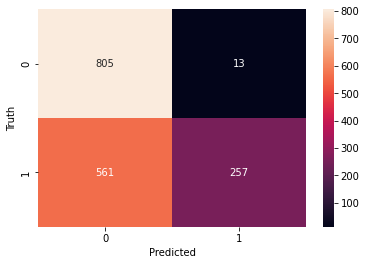

In [ ]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

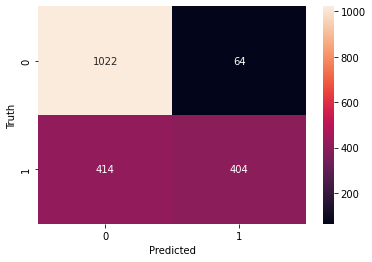

In [ ]:
sn.heatmap(cm_2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))
print(classification_report(y_test_2, y_predicted_2))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74       818
           1       0.95      0.31      0.47       818

    accuracy                           0.65      1636
   macro avg       0.77      0.65      0.60      1636
weighted avg       0.77      0.65      0.60      1636

              precision    recall  f1-score   support

           0       0.71      0.94      0.81      1086
           1       0.86      0.49      0.63       818

    accuracy                           0.75      1904
   macro avg       0.79      0.72      0.72      1904
weighted avg       0.78      0.75      0.73      1904

